# Pull Request n.3 (#...)

## Explore lru caching for pauli commutators

Add a `lru_cache` decorator to `PauliWord.commutator` method.

We should be careful with adding such caching decorators, because when used uncarefully, they may accumulate a lot of memory.

For that, **test how much memory is accumulated for a controlled number of operators (bonus: do a #ops vs memory graph).**

Also, **check for some of the larger molecular Hamiltonians with ~20 qubits:**

- **how much memory is accumulated and**
- **how large the speed-up is for computing different commutators.**

Some more background https://xanaduhq.slack.com/archives/C06DX049G49/p1706641024337299

AC:

Decision is made on whether or not to include lru cache
if positive, PR to include that merged

In [1]:
import functools
import sys
import matplotlib.pyplot as plt


# Decorator to cache function results and track memory usage
def memoize(func):
    print(f"memoize function called (with argument {func})")
    cache = functools.lru_cache(maxsize=None)(func)
    # We create a dictionary cache_memory_usage to track the memory usage of each cached result.
    cache_mem_tracker = {}

    # we define a new function memoizer inside the memoize function, which wraps around the original function (func).
    @functools.wraps(func)
    def memoizer(*args, **kwargs):
        print(f"memoizer function called (with args = {args}, kwargs = {kwargs})")
        result = cache(*args, **kwargs)
        cache_mem_tracker[args[0]] = sys.getsizeof(result)
        return result

    memoizer.cache = cache
    memoizer.cache_mem_tracker = cache_mem_tracker
    memoizer.tot_cache_mem_allocated = lambda: sum(cache_mem_tracker.values())
    memoizer.clear = lambda: (cache_mem_tracker.clear(), cache.cache_clear())

    return memoizer


@memoize
def funza(n: float):
    return n

memoize function called (with argument <function funza at 0x7fd01d5d63a0>)


In [2]:
funza(30)
funza(35)
funza(50)
funza(50)

memoizer function called (with args = (30,), kwargs = {})
memoizer function called (with args = (35,), kwargs = {})
memoizer function called (with args = (50,), kwargs = {})
memoizer function called (with args = (50,), kwargs = {})


50

In [3]:
# funza.clear()

In [4]:
funza.tot_cache_mem_allocated()

84

In [5]:
funza.cache.cache_info()

CacheInfo(hits=1, misses=3, maxsize=None, currsize=3)

In [6]:
funza.cache_mem_tracker

{30: 28, 35: 28, 50: 28}

{}
memoizer function called (with args = (1,), kwargs = {})
{1: 28}
memoizer function called (with args = (2,), kwargs = {})
{1: 28, 2: 28}
memoizer function called (with args = (3,), kwargs = {})
{1: 28, 2: 28, 3: 28}
memoizer function called (with args = (4,), kwargs = {})
{1: 28, 2: 28, 3: 28, 4: 28}
memoizer function called (with args = (5,), kwargs = {})
{1: 28, 2: 28, 3: 28, 4: 28, 5: 28}
memoizer function called (with args = (6,), kwargs = {})
{1: 28, 2: 28, 3: 28, 4: 28, 5: 28, 6: 28}
memoizer function called (with args = (7,), kwargs = {})
{1: 28, 2: 28, 3: 28, 4: 28, 5: 28, 6: 28, 7: 28}
memoizer function called (with args = (8,), kwargs = {})
{1: 28, 2: 28, 3: 28, 4: 28, 5: 28, 6: 28, 7: 28, 8: 28}
memoizer function called (with args = (9,), kwargs = {})


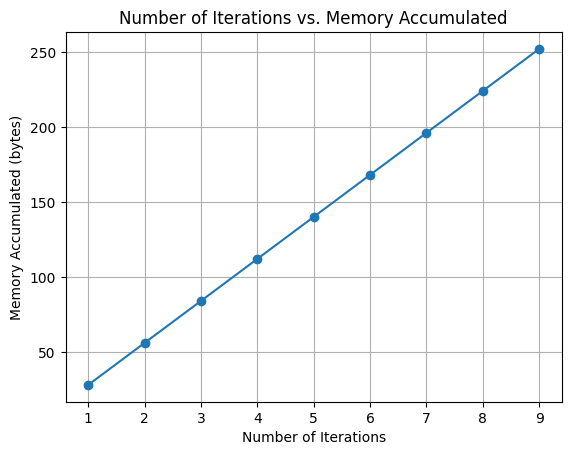

In [7]:
funza.clear()

# Perform iterations and measure memory usage
iterations = list(range(1, 10))  # Number of iterations
memory_usage = []

for i in iterations:
    print(funza.cache_mem_tracker)
    funza(i)
    memory_usage.append(funza.tot_cache_mem_allocated())

# Plotting
plt.plot(iterations, memory_usage, marker="o")
plt.xlabel("Number of Iterations")
plt.ylabel("Memory Accumulated (bytes)")
plt.title("Number of Iterations vs. Memory Accumulated")
plt.grid(True)
plt.show()

## Putting this into a `Pauli` class

In [8]:
# Decorator to cache function results and track memory usage
def _memoize(func):
    cache = functools.lru_cache(maxsize=None)(func)
    cache_mem_tracker = {}

    @functools.wraps(func)
    def memoizer(self, other):
        result = cache(self, other)
        cache_mem_tracker[(self.value, other.value)] = sys.getsizeof(result)
        return result

    memoizer.cache = cache
    memoizer.cache_mem_tracker = cache_mem_tracker
    memoizer.tot_cache_mem_allocated = lambda: sum(cache_mem_tracker.values())
    memoizer.clear = lambda: (cache_mem_tracker.clear(), cache.cache_clear())

    return memoizer


class Pauli:
    def __init__(self, value):
        self.value = value

    # Method to print the value of Pauli object
    def __repr__(self):
        return f"Pauli({self.value})"

    def _commutator(self, other):
        return self.value * other.value - other.value * self.value

    # Method to compute the result using memoization
    @_memoize
    def commutator(self, other):
        return self._commutator(other)
        # return self.value * other_pauli.value - other_pauli.value * self.value


# Define the Pauli class instances
pauli1 = Pauli(10)
pauli2 = Pauli(20)
pauli3 = Pauli(30)

# Call the `commutator` method
pauli1.commutator(pauli2)
pauli1.commutator(pauli3)
pauli1.commutator(pauli2)

0

In [9]:
print(f"{pauli1}")

Pauli(10)


In [10]:
pauli1.commutator.cache_mem_tracker

{(10, 20): 24, (10, 30): 24}

In [11]:
pauli1

Pauli(10)

## TODO: adding a `debug` mode

## Theory: PauliWord and PauliSentence

The single-qubit Pauli group consists of the four single-qubit Pauli operations `Identity`, `PauliX`, `PauliY` , and `PauliZ`. 

The n-qubit Pauli group is constructed by taking all possible N-fold tensor products of these elements. 
Elements of the n-qubit Pauli group are known as **Pauli words**, and have the form:

$$
P_J = \otimes_{i=1}^{n}\sigma_i^{(J)}
$$

where $\sigma_i^{(J)}$  is one of the Pauli operators (PauliX, PauliY, PauliZ) or identity (Identity) acting on the ith qubit. 
The full n -qubit Pauli group has size $4^n$  (neglecting the four possible global phases that may arise from multiplication of its elements).

PauliWord is a lightweight class which uses a dictionary approach to represent Pauli words. A PauliWord can be instantiated by passing a dictionary of wires and their associated Pauli operators.

### Step 1: playing with `PauliWords` and associated functions

In [12]:
import pennylane as qml
from pennylane.pauli import PauliWord

pw0 = PauliWord({0: "X"})
pw1 = PauliWord({0: "X"})
pw2 = PauliWord({0: "Y", 1: "X"})

print(f"pw0 = {pw0}")
print(f"pw0_mat = \n{pw0.to_mat(wire_order=[0, 1])}\n")

print(f"pw1 = {pw1}")
print(f"pw1_mat = \n{pw1.to_mat(wire_order=[0, 1])}\n")

print(f"pw2 = {pw2}")
print(f"pw2_mat = \n{pw2.to_mat(wire_order=[0, 1])}\n")

FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata
FRISUS LOG: transform e' stata chiamata


The purpose of this class is to efficiently compute products of Pauli words and obtain the matrix representation.

In [13]:
pw01 = pw0 @ pw1

print(f"pw01 = {pw01}")
print(f"pw01_mat = \n{pw01.to_mat()}\n")

pw02 = pw0 @ pw2

print(f"pw02 = {pw02}")
print(f"pw02_mat = \n{pw02.to_mat()}\n")

pw01 = 1 * I
pw01_mat = 
[[1.]]

pw02 = 1j * Z(0) @ X(1)
pw02_mat = 
[[ 0.+0.j  0.+1.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j -0.-1.j  0.+0.j]]



In [14]:
pw1.items

<function PauliWord.items>

In [15]:
pw1.commutator(pw2)

2j * Z(0) @ X(1)

In [16]:
pw1.to_mat()

array([[0., 1.],
       [1., 0.]])

In [17]:
pw1

X(0)

In [18]:
pw0.to_mat()

array([[0., 1.],
       [1., 0.]])

In [19]:
# pw1.commutator.cache_mem_tracker

Heavier Pauli Words

In [20]:
pauliword1 = PauliWord(
    {
        0: "Y",
        1: "Y",
        2: "Z",
        3: "X",
        4: "Y",
        5: "Z",
        6: "Y",
        7: "Y",
        8: "Z",
        9: "X",
        10: "Y",
        11: "Y",
        12: "X",
        13: "X",
        14: "X",
        15: "X",
        16: "Z",
        17: "Z",
        18: "Y",
        19: "Y",
        20: "X",
        21: "X",
        22: "X",
        23: "X",
        24: "Z",
        25: "Z",
        26: "Y",
        27: "Y",
        28: "Y",
        29: "X",
        30: "X",
        31: "X",
        32: "X",
        33: "Z",
        34: "Z",
        35: "Y",
        36: "Z",
        37: "Z",
        38: "Y",
        39: "Y",
        40: "Y",
        41: "X",
        42: "X",
        43: "X",
        44: "X",
        45: "Z",
        46: "Z",
        47: "Y",
    }
)
pauliword2 = PauliWord(
    {
        0: "X",
        1: "X",
        2: "X",
        3: "Y",
        4: "Z",
        5: "X",
        6: "X",
        7: "X",
        8: "X",
        9: "Z",
        10: "Z",
        11: "Y",
        12: "Z",
        13: "Z",
        14: "Z",
        15: "Y",
        16: "X",
        17: "X",
        18: "X",
        19: "X",
        20: "X",
        21: "Y",
        22: "Z",
        23: "X",
        24: "X",
        25: "X",
        26: "Y",
        27: "X",
    }
)


print(f"pauliword1 = {pauliword1}")
# print(f"pw0_mat = \n{pw0.to_mat()}\n")

print(f"pauliword2 = {pauliword2}")
# print(f"pw1_mat = \n{pw1.to_mat()}\n")

pauliword1.commutes_with(pauliword2)

pauliword1 = Y(0) @ Y(1) @ Z(2) @ X(3) @ Y(4) @ Z(5) @ Y(6) @ Y(7) @ Z(8) @ X(9) @ Y(10) @ Y(11) @ X(12) @ X(13) @ X(14) @ X(15) @ Z(16) @ Z(17) @ Y(18) @ Y(19) @ X(20) @ X(21) @ X(22) @ X(23) @ Z(24) @ Z(25) @ Y(26) @ Y(27) @ Y(28) @ X(29) @ X(30) @ X(31) @ X(32) @ Z(33) @ Z(34) @ Y(35) @ Z(36) @ Z(37) @ Y(38) @ Y(39) @ Y(40) @ X(41) @ X(42) @ X(43) @ X(44) @ Z(45) @ Z(46) @ Y(47)
pauliword2 = X(0) @ X(1) @ X(2) @ Y(3) @ Z(4) @ X(5) @ X(6) @ X(7) @ X(8) @ Z(9) @ Z(10) @ Y(11) @ Z(12) @ Z(13) @ Z(14) @ Y(15) @ X(16) @ X(17) @ X(18) @ X(19) @ X(20) @ Y(21) @ Z(22) @ X(23) @ X(24) @ X(25) @ Y(26) @ X(27)


True

In [21]:
import time

In [22]:
# pauliword1.commutator.cache_mem_tracker

In [23]:
# Get the current time before running the code
start_time = time.time()

# Run your function
pauliword1.commutator(pauliword2)

# Get the current time after running the code
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 0.00010728836059570312 seconds


In [24]:
len(pauliword1._commutator.cache_mem_tracker)

2

In [25]:
pauliword1._commutator.cache.cache_info()

CacheInfo(hits=0, misses=2, maxsize=None, currsize=2)

In [26]:
len(pauliword1._commutator.cache_mem_tracker)

2

## Random PauliWords generator

In [27]:
import random


def random_PauliWord_generator(
    lower_bound: int, upper_bound: int, directions: list = ["X", "Y", "Z"]
) -> PauliWord:
    "Generates a random Pauli Word."

    random.shuffle(directions)
    Pauli_arg = {}
    for i in range(lower_bound, upper_bound):
        if i - lower_bound < len(directions):
            Pauli_arg[i] = directions[i - lower_bound]
        else:
            Pauli_arg[i] = random.choice(directions)
    return PauliWord(Pauli_arg)

In [28]:
LOWER_BOUND = 0
UPPER_BOUND = 15

bounds = [random.randint(LOWER_BOUND, UPPER_BOUND), random.randint(LOWER_BOUND, UPPER_BOUND)]
bounds.sort()
random_PauliWord = random_PauliWord_generator(bounds[0], bounds[1])

print(random_PauliWord)

Z(5)


# Measuring cache memory usage

In [29]:
N_COMMUTATORS = 100

LOWER_BOUND = 0
UPPER_BOUND = 9
REPETITIONS_ALLOWED = True

iterations = list(range(1, N_COMMUTATORS + 1))

memory_usage = []

PauliWord._commutator.clear()

# while len(PauliWord._commutator.cache_mem_tracker) < N_COMMUTATORS:

counter = 0

while counter < N_COMMUTATORS:

    bounds = [random.randint(LOWER_BOUND, UPPER_BOUND), random.randint(LOWER_BOUND, UPPER_BOUND)]
    bounds.sort()
    random_PauliWord_1 = random_PauliWord_generator(bounds[0], bounds[1])
    random_PauliWord_2 = random_PauliWord_generator(bounds[0], bounds[1])

    if not REPETITIONS_ALLOWED:
        if (
            str(random_PauliWord_1),
            str(random_PauliWord_2),
        ) in PauliWord._commutator.cache_mem_tracker:
            continue

    counter += 1
    random_PauliWord_1._commutator(random_PauliWord_2)
    memory_usage.append(PauliWord._commutator.tot_cache_mem_allocated())

if not REPETITIONS_ALLOWED:
    assert len(PauliWord._commutator.cache_mem_tracker) == N_COMMUTATORS

# DOUBLE CHECK
# If `REPETITIONS_ALLOWED` is `False`, then `N_COMMUTATORS` should be equal to `currsize` displayed below
PauliWord._commutator.cache.cache_info()

CacheInfo(hits=17, misses=83, maxsize=None, currsize=83)

In [30]:
def CacheMemoryUsage(num_commutators, lower_bound, upper_bound, repetitions_allowed):
    "Measures how much cache memory is allocated."

    PauliWord._commutator.clear()

    iterations = list(range(1, num_commutators + 1))
    memory_usage = []
    counter = 0

    while counter < num_commutators:

        bounds = [
            random.randint(lower_bound, upper_bound),
            random.randint(lower_bound, upper_bound),
        ]
        bounds.sort()
        random_PauliWord_1 = random_PauliWord_generator(bounds[0], bounds[1])
        random_PauliWord_2 = random_PauliWord_generator(bounds[0], bounds[1])

        if not repetitions_allowed:
            if (
                str(random_PauliWord_1),
                str(random_PauliWord_2),
            ) in PauliWord._commutator.cache_mem_tracker:
                continue

        counter += 1
        random_PauliWord_1._commutator(random_PauliWord_2)
        memory_usage.append(PauliWord._commutator.tot_cache_mem_allocated())

    if not repetitions_allowed:
        assert len(PauliWord._commutator.cache_mem_tracker) == num_commutators

    # TODO: label should be more complete, but we don't care about it
    if repetitions_allowed:
        label = f"Repetitions: {repetitions_allowed}, Max qbits: {upper_bound-lower_bound+1}"
    else:
        label = f"Repetitions: {repetitions_allowed}"

    # DOUBLE CHECK
    # If `repetitions_allowed` is `False`, then `num_commutators` should be equal to `currsize` displayed below
    print(PauliWord._commutator.cache.cache_info())

    return iterations, memory_usage, label

In [31]:
N_COMMUTATORS = 100
LOWER_BOUND = 0
UPPER_BOUND_LIST = [9, 2, 3, 5, 9]
REPETITIONS_ALLOWED_LIST = [False, True, True, True, True]

data = []

for upper_bound, repetitions_allowed in zip(UPPER_BOUND_LIST, REPETITIONS_ALLOWED_LIST):
    iterations, memory_usage, label = CacheMemoryUsage(
        N_COMMUTATORS,
        LOWER_BOUND,
        upper_bound,
        repetitions_allowed,
    )
    data.append([iterations, memory_usage, label])

# data[ITERATION_INDEX][DATA_INDEX]
# DATA_INDEX = 0 --> iterations
# DATA_INDEX = 1 --> memory allocated
# DATA_INDEX = 2 --> label

CacheInfo(hits=0, misses=100, maxsize=None, currsize=100)
CacheInfo(hits=66, misses=34, maxsize=None, currsize=34)
CacheInfo(hits=46, misses=54, maxsize=None, currsize=54)
CacheInfo(hits=23, misses=77, maxsize=None, currsize=77)
CacheInfo(hits=17, misses=83, maxsize=None, currsize=83)


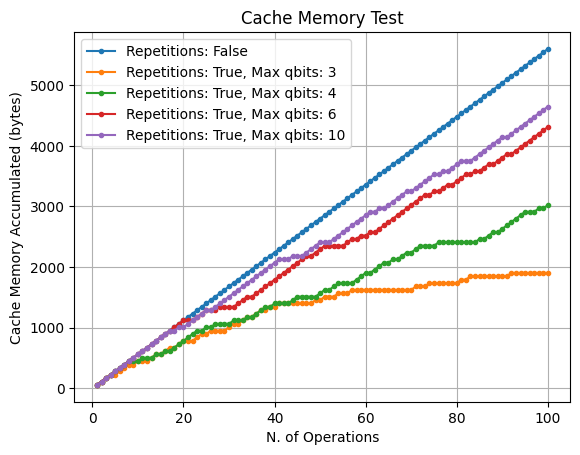

In [32]:
SAVE_FIGURE = False

for iteration_idx in range(len(data)):
    plt.plot(
        data[iteration_idx][0],
        data[iteration_idx][1],
        label=data[iteration_idx][2],
        marker="o",
        markersize=3,
    )
plt.xlabel("N. of Operations")
plt.ylabel("Cache Memory Accumulated (bytes)")
plt.title(f"Cache Memory Test")
plt.grid(True)
plt.legend()
if SAVE_FIGURE:
    plt.savefig("./plots/CacheMemoryUsage.png")
plt.show()

## Comments: 

- There's not even need to perform a fit, since the memory accumulated is clearly **linear** in the number of computed commutators.
This makes a lot of sense, considering that all results stored in `PauliWord.commutator.cache_mem_tracker` have the same size (248 bytes). 
This is the size corresponding to a `PauliWord` and a `PauliSentence`.

- Increasing the gap between `UPPER_BOUND` and `LOWER_BOUND` up to 1000 units (wires) doesn't seems to affect the allocated memory at all.

- On the other hand, increasing the gap between `UPPER_BOUND` and `LOWER_BOUND` reduces the probability for the cache memory to be used, since the probability that two equal `PauliWords` are generated in the random process decreases accordingly.